In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from joblib import dump

In [2]:
input_file = "vibration_raw_data_all.csv"
CHUNKSIZE = 1_000_000

drop_cols = ["temperature", "sent_to_s3"]
vibration_cols = ["xs", "ys", "zs", "xd", "yd", "zd", "xa", "ya", "za"]


# DATA PROCESSING
def process_chunk(chunk):
    chunk = chunk.drop(columns=drop_cols, errors="ignore")
    
    chunk = chunk.drop_duplicates()
    chunk = chunk.dropna(subset=vibration_cols)
    
    chunk = chunk[(chunk[vibration_cols] != 0).any(axis=1)]
    
    chunk["timestamp"] = pd.to_datetime(chunk["timestamp"], errors="coerce")
    chunk = chunk.dropna(subset=["timestamp"])
    
    chunk["bin_3s"] = chunk["timestamp"].dt.floor("3S")
    
    rms_chunk = chunk.groupby(["bin_3s", "device_id", "sensor_id"], as_index=False)[vibration_cols].agg(
        lambda x: np.sqrt(np.mean(x**2))
    )
    
    return rms_chunk


results = [process_chunk(chunk) for chunk in pd.read_csv(input_file, chunksize=CHUNKSIZE)]

df_3s = pd.concat(results, ignore_index=True)

df_3s = df_3s.groupby(["bin_3s", "device_id", "sensor_id"], as_index=False)[vibration_cols].mean()

df_3s = df_3s.rename(columns={"bin_3s": "timestamp"})
df_3s.head()

/tmp/ipykernel_29714/905735671.py:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  chunk["bin_3s"] = chunk["timestamp"].dt.floor("3S")
/tmp/ipykernel_29714/905735671.py:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  chunk["bin_3s"] = chunk["timestamp"].dt.floor("3S")
/tmp/ipykernel_29714/905735671.py:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  chunk["bin_3s"] = chunk["timestamp"].dt.floor("3S")
/tmp/ipykernel_29714/905735671.py:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  chunk["bin_3s"] = chunk["timestamp"].dt.floor("3S")
/tmp/ipykernel_29714/905735671.py:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  chunk["bin_3s"] = chunk["timestamp"].dt.floor("3S")
/tmp/ipykernel_29714/905735671.py:20: FutureWarnin

,timestamp,device_id,sensor_id,xs,ys,zs,xd,yd,zd,xa,ya,za
0,2025-08-14 03:07:24,L2,12,0.149706,0.350074,0.169084,0.01,0.03,0.019665,0.0,0.0,7.7
1,2025-08-14 03:07:27,L2,12,0.134859,0.315163,0.151743,0.01,0.03,0.013831,0.0,0.0,7.7
2,2025-08-14 03:07:27,L2,13,0.045764,0.073336,0.087425,0.00,0.01,0.010000,0.0,0.0,7.7
3,2025-08-14 03:07:30,L2,13,0.050627,0.070000,0.089188,0.00,0.01,0.010000,0.0,0.0,7.7
4,2025-08-14 03:07:30,L2,14,0.330000,0.480000,0.280000,0.03,0.05,0.030000,0.0,0.0,7.7


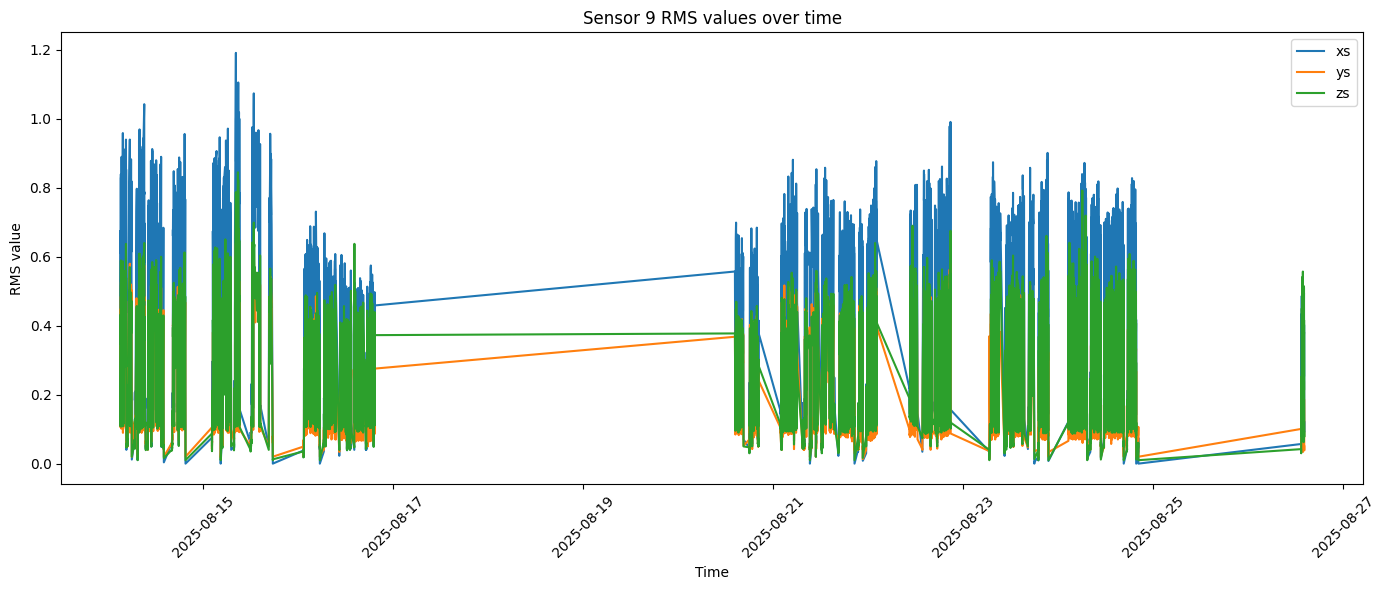

In [3]:
sensor_id = 9
sensor_data = df_3s[df_3s["sensor_id"] == sensor_id]

plt.figure(figsize=(14, 6))
plt.plot(sensor_data["timestamp"], sensor_data["xs"], label="xs")
plt.plot(sensor_data["timestamp"], sensor_data["ys"], label="ys")
plt.plot(sensor_data["timestamp"], sensor_data["zs"], label="zs")
plt.xlabel("Time")
plt.ylabel("RMS value")
plt.title(f"Sensor {sensor_id} RMS values over time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

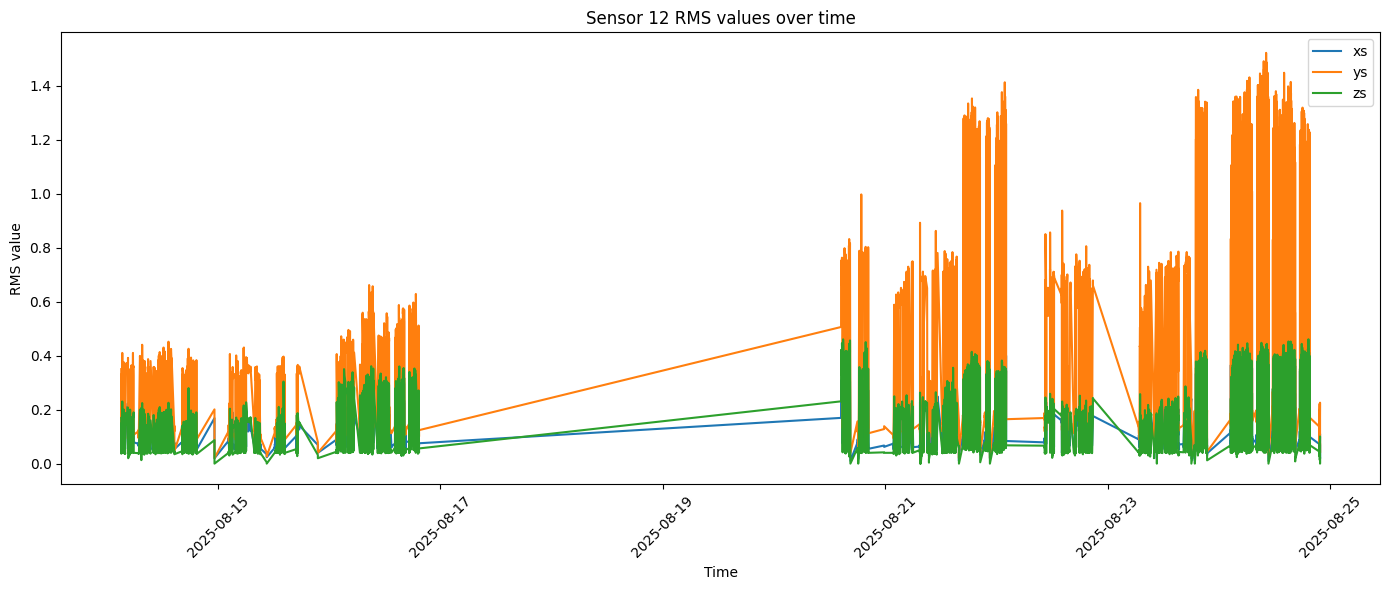

In [4]:
sensor_id = 12
sensor_data = df_3s[df_3s["sensor_id"] == sensor_id]

plt.figure(figsize=(14, 6))
plt.plot(sensor_data["timestamp"], sensor_data["xs"], label="xs")
plt.plot(sensor_data["timestamp"], sensor_data["ys"], label="ys")
plt.plot(sensor_data["timestamp"], sensor_data["zs"], label="zs")
plt.xlabel("Time")
plt.ylabel("RMS value")
plt.title(f"Sensor {sensor_id} RMS values over time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# ANOMALY DETECTION
features = vibration_cols
df_3s["anomaly"] = False
df_3s["anomaly_score"] = np.nan

for sensor in df_3s["sensor_id"].unique():
    sensor_mask = df_3s["sensor_id"] == sensor
    X = df_3s.loc[sensor_mask, features].values
    
    # Scale features to avoid bias
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train Isolation Forest
    iso = IsolationForest(
        n_estimators=200,      
        contamination=0.01, 
        random_state=42,
        n_jobs=-1             
    )
    iso.fit(X_scaled)
    
    # Save model + scaler per sensor
    dump({"model": iso, "scaler": scaler}, f"isolation_forest_sensor_{sensor}.pkl")
    
    # Predict anomalies
    preds = iso.predict(X_scaled)  # 1 = normal, -1 = anomaly
    df_3s.loc[sensor_mask, "anomaly"] = preds == -1
    df_3s.loc[sensor_mask, "anomaly_score"] = iso.decision_function(X_scaled)

    
# SAVE OUTPUT
df_3s.to_csv("vibration_data_anomalies_all_sensors.csv", index=False)
print("Processing done. Total anomalies detected:", df_3s["anomaly"].sum())
df_3s.head()

Processing done. Total anomalies detected: 1091


,timestamp,device_id,sensor_id,xs,ys,zs,xd,yd,zd,xa,ya,za,anomaly,anomaly_score
0,2025-08-14 03:07:24,L2,12,0.149706,0.350074,0.169084,0.01,0.03,0.019665,0.0,0.0,7.7,False,0.168240
1,2025-08-14 03:07:27,L2,12,0.134859,0.315163,0.151743,0.01,0.03,0.013831,0.0,0.0,7.7,False,0.174603
2,2025-08-14 03:07:27,L2,13,0.045764,0.073336,0.087425,0.00,0.01,0.010000,0.0,0.0,7.7,False,0.222031
3,2025-08-14 03:07:30,L2,13,0.050627,0.070000,0.089188,0.00,0.01,0.010000,0.0,0.0,7.7,False,0.219619
4,2025-08-14 03:07:30,L2,14,0.330000,0.480000,0.280000,0.03,0.05,0.030000,0.0,0.0,7.7,False,0.145018


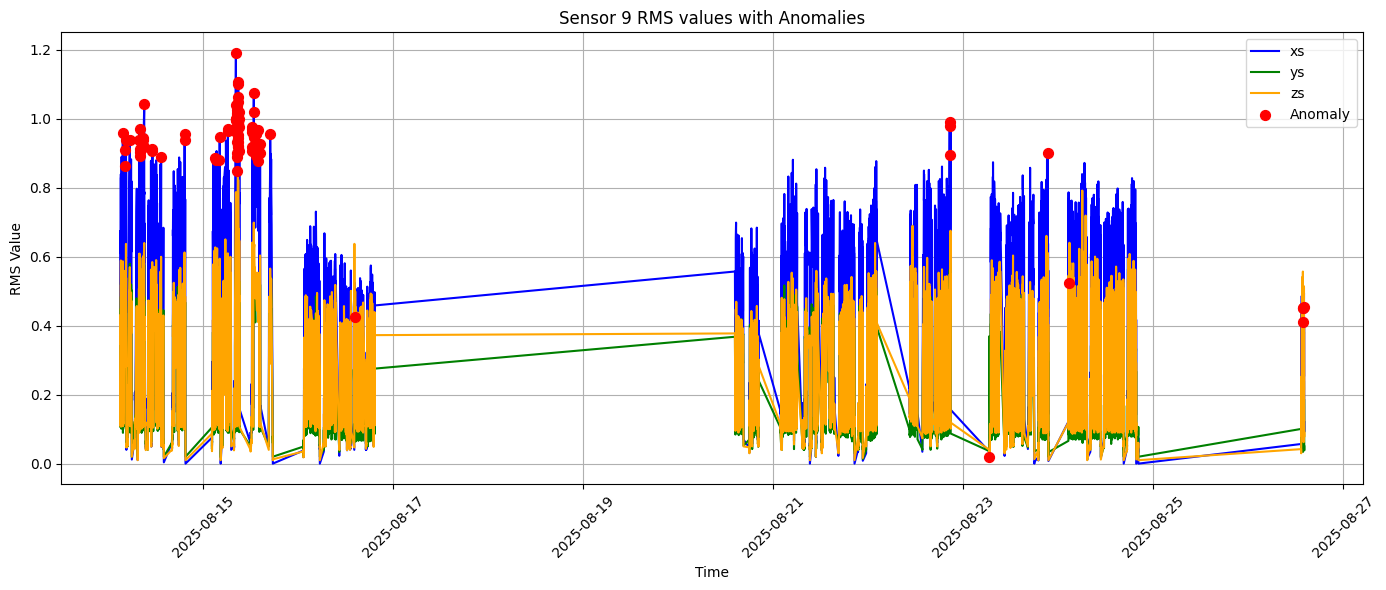

In [7]:

sensor_id = 9
sensor_data = df_3s[df_3s["sensor_id"] == sensor_id]

plt.figure(figsize=(14, 6))

# Plot RMS axes
plt.plot(sensor_data["timestamp"], sensor_data["xs"], label="xs", color='blue')
plt.plot(sensor_data["timestamp"], sensor_data["ys"], label="ys", color='green')
plt.plot(sensor_data["timestamp"], sensor_data["zs"], label="zs", color='orange')

# Highlight anomalies in red (for xs axis)
plt.scatter(
    sensor_data["timestamp"][sensor_data["anomaly"]],
    sensor_data["xs"][sensor_data["anomaly"]],
    color='red',
    label="Anomaly",
    s=50,
    zorder=5
)

plt.xlabel("Time")
plt.ylabel("RMS Value")
plt.title(f"Sensor {sensor_id} RMS values with Anomalies")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


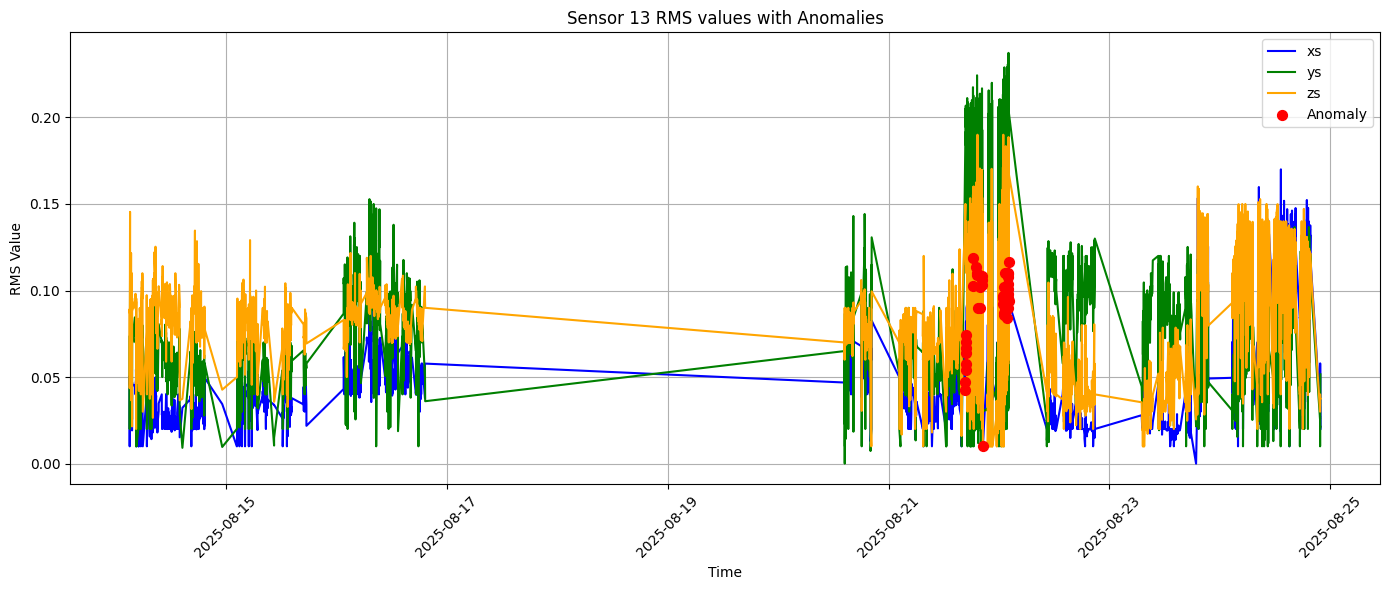

In [8]:

sensor_id = 13
sensor_data = df_3s[df_3s["sensor_id"] == sensor_id]

plt.figure(figsize=(14, 6))

# Plot RMS axes
plt.plot(sensor_data["timestamp"], sensor_data["xs"], label="xs", color='blue')
plt.plot(sensor_data["timestamp"], sensor_data["ys"], label="ys", color='green')
plt.plot(sensor_data["timestamp"], sensor_data["zs"], label="zs", color='orange')

# Highlight anomalies in red (for xs axis)
plt.scatter(
    sensor_data["timestamp"][sensor_data["anomaly"]],
    sensor_data["xs"][sensor_data["anomaly"]],
    color='red',
    label="Anomaly",
    s=50,
    zorder=5
)

plt.xlabel("Time")
plt.ylabel("RMS Value")
plt.title(f"Sensor {sensor_id} RMS values with Anomalies")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


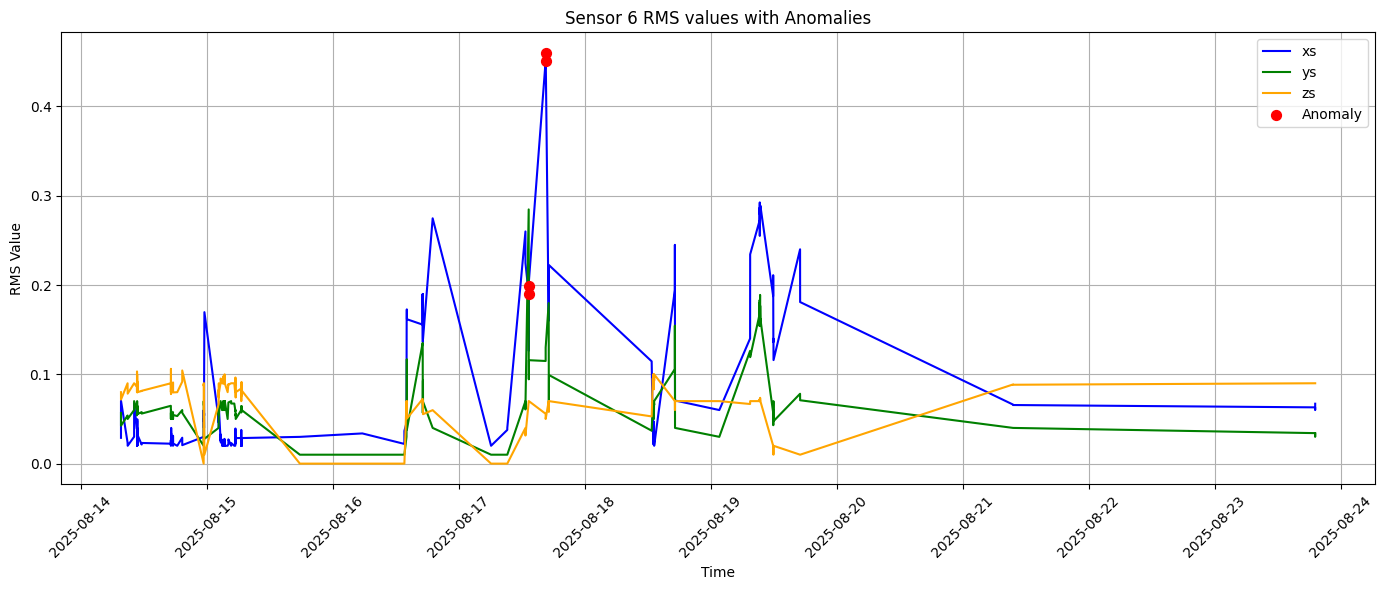

In [9]:

sensor_id = 6
sensor_data = df_3s[df_3s["sensor_id"] == sensor_id]

plt.figure(figsize=(14, 6))

# Plot RMS axes
plt.plot(sensor_data["timestamp"], sensor_data["xs"], label="xs", color='blue')
plt.plot(sensor_data["timestamp"], sensor_data["ys"], label="ys", color='green')
plt.plot(sensor_data["timestamp"], sensor_data["zs"], label="zs", color='orange')

# Highlight anomalies in red (for xs axis)
plt.scatter(
    sensor_data["timestamp"][sensor_data["anomaly"]],
    sensor_data["xs"][sensor_data["anomaly"]],
    color='red',
    label="Anomaly",
    s=50,
    zorder=5
)

plt.xlabel("Time")
plt.ylabel("RMS Value")
plt.title(f"Sensor {sensor_id} RMS values with Anomalies")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
